### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [99]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [100]:
# Defining important metrics and functions

# Setting NSIDE valuesfrom sklearn.model_selection import train_test_split
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))


def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### 1. Get a catalogue of all objects in the Galaxy Survey



In [101]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,541202,140.895285,39.405974,0,0,1
1,541202,140.895584,39.576038,0,0,1
2,541202,140.895693,39.403449,0,0,1
3,541202,140.896081,39.479529,0,0,1
4,541202,140.896304,39.621573,0,1,0


In [102]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,387694,350.870568,9.868695,1,0,0
1,387694,350.871680,9.637755,0,1,0
2,387694,350.872142,9.694869,0,0,1
3,387694,350.872631,9.724626,0,0,1
4,387694,350.873243,9.683394,0,1,0


In [103]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
234366
323451


In [104]:
df = pd.concat((df_south, df_north), axis=0)

In [105]:
print(len(df))

113951827


In [106]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

(113951827, 6)
(113917506, 6)


In [107]:
df = duplicates_removed

print(len(df.BrickID.unique()))

312951


In [108]:
print(df.isna().sum())

BrickID         0
RA         137580
DEC        137580
LRG             0
ELG             0
QSO             0
dtype: int64


In [109]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

306930
113779926


### 2. Get Galaxy Count per Healpy Pixel


In [110]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 12672241
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 33.64496370597325


,pixel_id,lrg
0,1558,2
1,1560,1
2,1561,3
3,1562,1
4,1564,2


In [111]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 47329576
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 125.14628999931253
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


In [112]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 59210251
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 156.4951447329471
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [113]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id       0
lrg         2018
elg          470
qso          312
dtype: int64
(376646, 2) (378194, 2) (378352, 2) (378664, 4)


In [114]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print(df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(376423, 4)


### 3. Plotting Galaxy Densities

0.0 180.0 -180.0 180.0


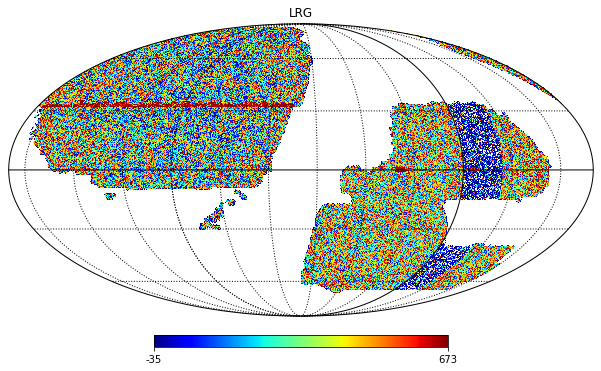

In [115]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


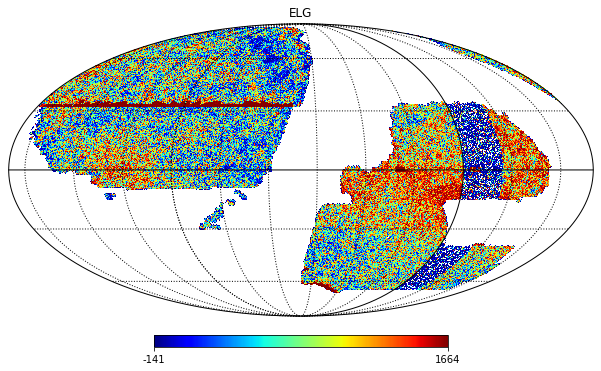

In [116]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


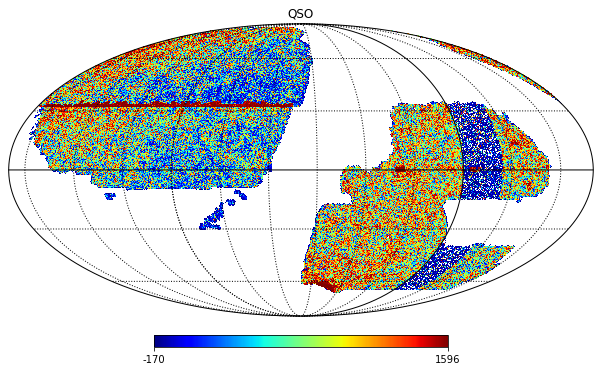

In [117]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [118]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [119]:
df = df.astype(int)
df.head()



,pixel_id,lrg,elg,qso
0,1558,2,6,9
1,1560,1,7,8
2,1561,3,4,6
3,1562,1,5,6
4,1564,2,4,10


In [120]:
pix_ids = df.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df['exposures'] = exp_len

df.head()

[  1558   1560   1561 ... 757955 758427 758428]
[10. 11. 10. ...  8.  6.  9.]


,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,10.0
1,1560,1,7,8,11.0
2,1561,3,4,6,10.0
3,1562,1,5,6,10.0
4,1564,2,4,10,10.0


In [121]:
df = df.astype(int)


0.0 180.0 -180.0 180.0


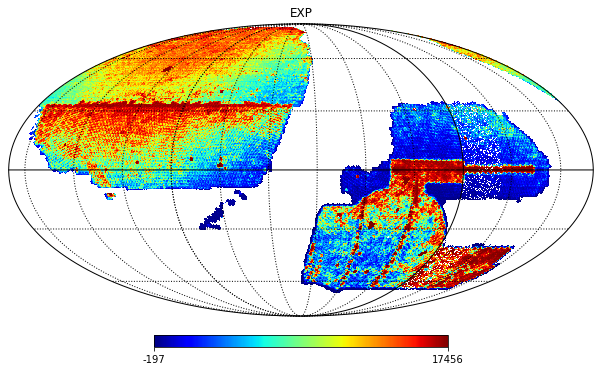

In [122]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [123]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [124]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [125]:
df_stellar_north.head()

,RA,DEC,GMAG,RMAG,ZMAG
0,140.898014,39.467598,18.104998,17.247044,16.888790
1,140.931050,39.523490,18.810522,17.796021,17.333416
2,140.957915,39.428128,19.376871,17.902054,16.362108
3,140.972733,39.467930,19.390877,17.886087,16.718546
4,140.981984,39.563177,18.225065,17.742722,17.618404


In [126]:
print(len(df_stellar_north) + len(df_stellar_south))

12947797


In [127]:
df_stellar = pd.concat((df_stellar_south, df_stellar_north), axis=0)


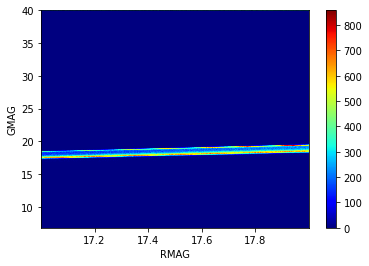

In [128]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [129]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(12947797, 5)


In [130]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [131]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


(12334252, 7)


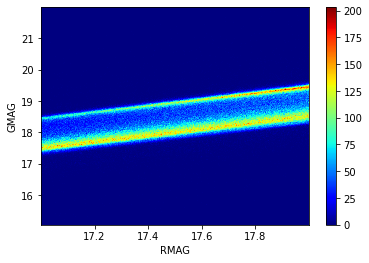

In [132]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [133]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


269    12372
843    12368
118    12367
369    12367
109    12367
       ...  
125    12299
171    12299
617    12299
270    12299
844    12294
Name: percent_RMAG, Length: 1000, dtype: int64

In [134]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [135]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(12334252, 12)

In [136]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [137]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [138]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(12334252, 12)
(12243663, 12)


(12188489, 12)

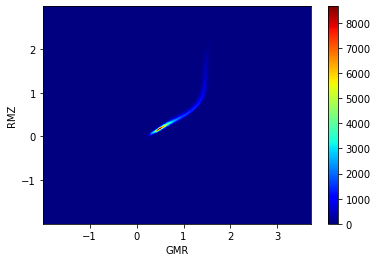

In [139]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [140]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 12188489
[  1560   1561   1562 ... 757955 758426 758427]
Mean stellars per Pixel: 32.36704100953074
[[  1560      1]
 [  1561      3]
 [  1562      2]
 ...
 [757955      4]
 [758426      2]
 [758427      2]]
   pixel_id  stellar
0      1560        1
1      1561        3
2      1562        2
3      1565        3
4      1572        1
pixel_id    0
stellar     0
dtype: int64


In [141]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id     0
lrg          0
elg          0
qso          0
exposures    0
stellar      0
dtype: int64


(375445, 6)

In [142]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar
0,1560,1,7,8,11,1
1,1561,3,4,6,10,3
2,1562,1,5,6,10,2
3,1565,2,11,7,9,3
4,1572,1,3,10,6,1


0.0 180.0 -180.0 180.0


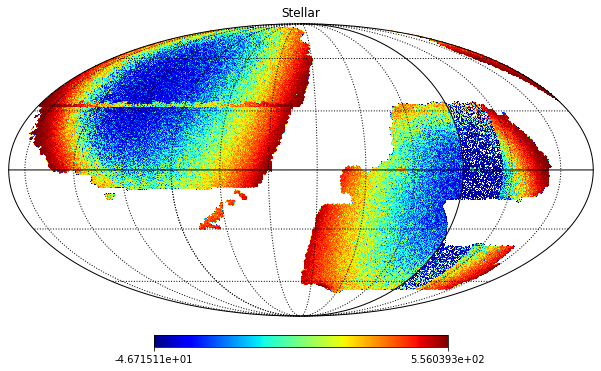

In [143]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [144]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [145]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [146]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1560   1561   1562 ... 757954 757955 758427]


In [147]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [148]:
df.EBV.describe()
df.head()


,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759


0.0 180.0 -180.0 180.0


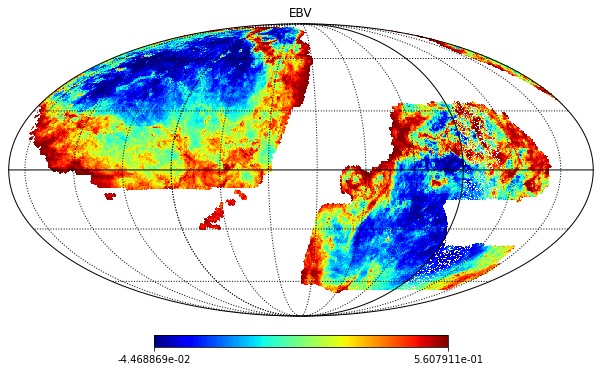

In [149]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [150]:
df.exposures = df.exposures.astype(int)
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759


In [151]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [152]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv',
                 dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                        'EBV': 'float'})

#### Geometric Systematics Values, not involving edge pixels

In [153]:
with open('../../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geo_dict = pickle.load(f)
    f.close()

print(len(geo_dict.keys()))

446042


In [154]:
sys_list = []
for key in geo_dict.keys():
    ind_sys_list = geo_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
                                                'ccdskysb_g',
                                                'ccdskysb_r',
                                                'ccdskysb_z',
                                                'exptime_g',
                                                'exptime_r',
                                                'exptime_z',
                                                'meansky_g',
                                                'meansky_r',
                                                'meansky_z',
                                                'galdepth_g',
                                                'galdepth_r',
                                                'galdepth_z',
                                                'seeing_g',
                                                'seeing_r',
                                                'seeing_z',
                                                'mjd_obs_g',
                                                'mjd_obs_r',
                                                'mjd_obs_z', 'pixel_id'])



In [155]:
print(len((df_sys_geo_no)))

446042


In [156]:
df_geo = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(len(df))
print(len(df_geo))

375445
373857


In [157]:
print(df_geo.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
exposures      0
stellar        0
EBV            0
airmass        0
ccdskysb_g    52
ccdskysb_r    33
ccdskysb_z     4
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
seeing_g       0
seeing_r       0
seeing_z       0
mjd_obs_g      0
mjd_obs_r      0
mjd_obs_z      0
dtype: int64


In [158]:
df_geo.dropna(axis=0, inplace=True)
print(df_geo.isna().sum())

pixel_id      0
lrg           0
elg           0
qso           0
exposures     0
stellar       0
EBV           0
airmass       0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
seeing_g      0
seeing_r      0
seeing_z      0
mjd_obs_g     0
mjd_obs_r     0
mjd_obs_z     0
dtype: int64


In [159]:
print(df_geo.describe())

            pixel_id            lrg            elg            qso  \
count  373775.000000  373775.000000  373775.000000  373775.000000   
mean   335796.311843      33.834582     126.292762     158.059908   
std    204659.393401      14.841393      36.199126      43.233023   
min      1667.000000       1.000000       1.000000       1.000000   
25%    174614.500000      26.000000     111.000000     140.000000   
50%    316602.000000      32.000000     126.000000     158.000000   
75%    461523.500000      40.000000     141.000000     177.000000   
max    757954.000000     708.000000    2936.000000    2040.000000   

          exposures        stellar            EBV        airmass  \
count  373775.00000  373775.000000  373775.000000  373775.000000   
mean       99.83889      32.484238       0.041954       1.354526   
std       248.37523      29.876966       0.032644       0.253739   
min         5.00000       1.000000       0.000583       1.000179   
25%        46.00000      15.000000    

In [160]:
df_geo.to_csv('../../bricks_data/dataset_geometric.csv', index=False)


#### Plotting All Densities and systematics together


In [161]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')

ValueError: list.remove(x): x not in list

In [ ]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]

    m = np.zeros(NPIX)

    m[df_geo.pixel_id.to_numpy()] = df_geo[elem].to_numpy()
    mask = (m == 0)
    m[mask] = np.nan
    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1),format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
    hp.graticule()
    i += 1

plt.show()


### 5. Outlier Removal

In [212]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

df_geo.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,meansky_z,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z
count,373775.000000,373775.000000,373775.000000,373775.000000,373775.00000,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000,...,3.737750e+05,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000,373775.000000
mean,335796.311843,33.834582,126.292762,158.059908,99.83889,32.484238,0.041954,1.354526,23.464030,22.586330,...,7.931913e+08,23.670178,23.155843,22.227863,1.226821,1.104229,1.101229,57796.141744,57786.022147,57682.863370
std,204659.393401,14.841393,36.199126,43.233023,248.37523,29.876966,0.032644,0.253739,0.181686,0.226631,...,3.245372e+09,0.300686,0.335663,0.264119,0.490387,0.323478,0.364320,355.725759,351.101517,305.214737
min,1667.000000,1.000000,1.000000,1.000000,5.00000,1.000000,0.000583,1.000179,18.267529,18.225866,...,0.000000e+00,18.361883,15.734725,0.000000,0.573780,0.542340,0.000000,56536.000831,56536.081054,0.000000
25%,174614.500000,26.000000,111.000000,140.000000,46.00000,15.000000,0.019672,1.182382,23.383527,22.475309,...,2.054452e+00,23.504177,22.937412,22.166478,1.090793,0.985373,0.992593,57529.466665,57512.560937,57476.804664
50%,316602.000000,32.000000,126.000000,158.000000,69.00000,22.000000,0.032656,1.272126,23.487371,22.610277,...,2.519110e+00,23.729109,23.227337,22.286677,1.240137,1.121795,1.078410,57799.892377,57778.781352,57653.574532
75%,461523.500000,40.000000,141.000000,177.000000,134.00000,39.000000,0.053331,1.487093,23.573118,22.726614,...,3.328381e+00,23.872800,23.357085,22.378283,1.353616,1.217455,1.179816,58067.183275,58058.920561,57878.026365
max,757954.000000,708.000000,2936.000000,2040.000000,17612.00000,1957.000000,0.854514,2.385126,24.377570,25.279337,...,9.433031e+10,24.705928,24.181324,27.191251,53.560776,32.342494,58.909491,58662.327740,58661.994609,58679.138231


In [213]:
zscore = lambda x: abs((x - x.median()) / x.std())
col = list(df_geo.columns)
df_no_outlier = df_geo


#### Removing All Outliers


In [214]:
df_no_outlier = df_geo

print(len(df_geo))
for elem in col:
    df_no_outlier['Z'] = df_no_outlier[elem].transform(zscore)
    print("Element: ", elem, "| No of Elems with Z > 4 : ", len(df_no_outlier[(df_no_outlier['Z'] > 4)]))
    df_no_outlier = df_no_outlier[(df_no_outlier['Z'] < 4)]

print()
print(f"Galaxies Remaining before outlier removal: {len(df_geo)}")
print(f"Galaxies Remaining after outlier removal: {len(df_no_outlier)}")
print(f"Elements cut by outlier removal: {len(df_geo) - len(df_no_outlier)}")

373775
Element:  pixel_id | No of Elems with Z > 4 :  0
Element:  lrg | No of Elems with Z > 4 :  2362
Element:  elg | No of Elems with Z > 4 :  2155
Element:  qso | No of Elems with Z > 4 :  1667
Element:  exposures | No of Elems with Z > 4 :  657
Element:  stellar | No of Elems with Z > 4 :  4945
Element:  EBV | No of Elems with Z > 4 :  3486
Element:  airmass | No of Elems with Z > 4 :  425
Element:  ccdskysb_g | No of Elems with Z > 4 :  2256
Element:  ccdskysb_r | No of Elems with Z > 4 :  2180
Element:  ccdskysb_z | No of Elems with Z > 4 :  22
Element:  exptime_g | No of Elems with Z > 4 :  546
Element:  exptime_r | No of Elems with Z > 4 :  2788
Element:  exptime_z | No of Elems with Z > 4 :  1181
Element:  meansky_g | No of Elems with Z > 4 :  7190
Element:  meansky_r | No of Elems with Z > 4 :  6396
Element:  meansky_z | No of Elems with Z > 4 :  6174
Element:  galdepth_g | No of Elems with Z > 4 :  1076
Element:  galdepth_r | No of Elems with Z > 4 :  977
Element:  galdepth_

In [215]:
df_no_outlier.describe()
print(df_no_outlier.shape)
print(df_no_outlier.exposures.max())

df_no_outlier = df_no_outlier[df_no_outlier.exposures < 500]
print(df_no_outlier.shape)

df_no_outlier.exposures.max()


(324339, 27)
1002
(324270, 27)


498

### Scaling the Data

In [216]:
scaler = MinMaxScaler()
#scaler = RobustScaler()

df_scaled = df_no_outlier

df_scaled[df_scaled.columns] = scaler.fit_transform(df_no_outlier[df_no_outlier.columns])

df_scaled.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,...,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000,324270.000000
mean,0.425321,0.357420,0.468221,0.495992,0.164511,0.209405,0.245158,0.280915,0.549179,0.501889,...,0.539134,0.543609,0.505856,0.408826,0.375590,0.293915,0.597817,0.594127,0.532113,0.205767
std,0.253515,0.129455,0.108204,0.116430,0.114631,0.175701,0.169845,0.198092,0.109451,0.111641,...,0.132015,0.136406,0.116502,0.132109,0.127178,0.089750,0.161774,0.160085,0.134620,0.160002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227251,0.277778,0.415730,0.440000,0.083164,0.094891,0.120310,0.147820,0.480437,0.433361,...,0.441649,0.442296,0.457054,0.325431,0.294948,0.231414,0.482293,0.470437,0.436704,0.079380
50%,0.406816,0.344444,0.471910,0.500000,0.125761,0.145985,0.198162,0.217115,0.559687,0.510478,...,0.564360,0.568382,0.524542,0.423759,0.390945,0.284331,0.600025,0.592127,0.518973,0.170234
75%,0.581811,0.422222,0.528090,0.560000,0.182556,0.255474,0.319086,0.382392,0.627688,0.577746,...,0.636428,0.626377,0.580430,0.497471,0.456688,0.345642,0.719352,0.716977,0.621615,0.298494
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating train, test and validation sets

In [217]:
df_train, df_val = train_test_split(df_scaled, test_size=0.4, random_state=666, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=666, shuffle=True)

total = len(df_train) + len(df_test) + len(df_val)

print(len(df_train)/total)
print(len(df_val)/total)
print(len(df_test)/total)

0.6
0.2
0.2


In [218]:
df_train.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,...,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000,194562.000000
mean,0.424998,0.357260,0.468335,0.496097,0.164499,0.209081,0.245009,0.280884,0.548995,0.501892,...,0.539044,0.543538,0.506084,0.408505,0.375412,0.293915,0.598071,0.594377,0.532348,0.205750
std,0.253365,0.129514,0.108155,0.116281,0.114681,0.175626,0.169784,0.197979,0.109510,0.111686,...,0.132104,0.136411,0.116256,0.131940,0.126998,0.089624,0.161676,0.159913,0.134545,0.159861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000281,0.000000,0.000000,...,0.000000,0.000000,0.000008,0.000000,0.010617,0.000000,0.000000,0.000000,0.000000,0.000001
25%,0.227028,0.277778,0.415730,0.440000,0.083164,0.094891,0.120253,0.147923,0.480385,0.433549,...,0.441434,0.441736,0.457188,0.325004,0.294376,0.231643,0.482564,0.470851,0.436861,0.079387
50%,0.406675,0.344444,0.471910,0.500000,0.125761,0.145985,0.197966,0.217322,0.559496,0.510480,...,0.564224,0.568318,0.525008,0.423519,0.391061,0.284222,0.600174,0.592321,0.519245,0.170324
75%,0.581663,0.422222,0.528090,0.560000,0.182556,0.255474,0.318928,0.382075,0.627387,0.577753,...,0.636393,0.626250,0.580535,0.497123,0.456627,0.345573,0.719799,0.717085,0.621898,0.298606
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999974,1.000000,1.000000,1.000000,...,0.992485,1.000000,0.984520,1.000000,1.000000,0.941241,1.000000,1.000000,1.000000,1.000000


In [219]:
df_val.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,...,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000
mean,0.425051,0.357766,0.468234,0.495595,0.163900,0.209942,0.244963,0.280855,0.549325,0.501636,...,0.539694,0.543314,0.506032,0.409259,0.375786,0.293954,0.598110,0.594243,0.532074,0.205894
std,0.252913,0.129709,0.108207,0.116593,0.114014,0.175657,0.168956,0.198296,0.109511,0.111539,...,0.131275,0.136501,0.116856,0.132267,0.127553,0.090027,0.162078,0.160479,0.134867,0.160595
min,0.000003,0.000000,0.007491,0.000000,0.000000,0.000000,0.010250,0.000680,0.001211,0.000298,...,0.000200,0.000386,0.000261,0.004586,0.000000,0.003903,0.000591,0.010335,0.000000,0.000000
25%,0.227281,0.277778,0.415730,0.440000,0.083164,0.094891,0.120756,0.147616,0.480708,0.432934,...,0.442465,0.442259,0.456885,0.325577,0.295769,0.231022,0.482912,0.470169,0.436699,0.079627
50%,0.406787,0.344444,0.471910,0.500000,0.125761,0.145985,0.198787,0.216669,0.559789,0.510545,...,0.564866,0.568451,0.524436,0.423774,0.390720,0.284585,0.600314,0.593803,0.519240,0.170021
75%,0.581593,0.433333,0.528090,0.560000,0.180527,0.255474,0.318393,0.383368,0.627826,0.577675,...,0.636449,0.625975,0.580850,0.497687,0.457037,0.346176,0.719665,0.716990,0.620984,0.297730
max,0.999363,1.000000,1.000000,1.000000,0.995943,1.000000,1.000000,0.999764,0.995489,0.854209,...,1.000000,0.989945,1.000000,0.977051,0.998223,1.000000,0.999010,0.999992,1.000000,1.000000


In [220]:
df_test.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,...,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,64854.000000,6.485400e+04
mean,0.426557,0.357557,0.467865,0.496075,0.165157,0.209838,0.245800,0.281068,0.549586,0.502132,...,0.538845,0.544115,0.504996,0.409357,0.375927,0.293874,0.596761,0.593263,0.531449,2.056898e-01
std,0.254562,0.129024,0.108351,0.116715,0.115095,0.175971,0.170910,0.198229,0.109213,0.111608,...,0.132486,0.136296,0.116881,0.132458,0.127344,0.089851,0.161761,0.160205,0.134597,1.598306e-01
min,0.000151,0.000000,0.000000,0.000000,0.000000,0.000000,0.011853,0.000000,0.001231,0.000174,...,0.001115,0.000613,0.000000,0.029806,0.010617,0.010439,0.004284,0.010831,0.007085,4.967673e-07
25%,0.228376,0.277778,0.415730,0.440000,0.083164,0.094891,0.120013,0.147806,0.480405,0.433182,...,0.441623,0.443636,0.456783,0.326047,0.296245,0.231120,0.479239,0.469684,0.436369,7.901846e-02
50%,0.407539,0.344444,0.471910,0.500000,0.125761,0.145985,0.198162,0.217113,0.560195,0.510416,...,0.564180,0.568501,0.523278,0.424528,0.390755,0.284383,0.599241,0.589405,0.517543,1.703337e-01
75%,0.583122,0.433333,0.524345,0.560000,0.184584,0.255474,0.320149,0.382408,0.628475,0.577822,...,0.636461,0.627159,0.579606,0.498368,0.456614,0.345317,0.717357,0.715827,0.621458,2.990244e-01
max,0.999367,1.000000,1.000000,1.000000,0.997972,1.000000,0.999602,0.998860,0.999228,0.984927,...,0.938866,0.997776,0.987778,0.976247,0.990572,0.881414,0.999010,0.999993,1.000000,9.863465e-01


In [221]:
df_train.to_csv('../../bricks_data/train.csv', index=False)
df_val.to_csv('../../bricks_data/val.csv', index=False)
df_test.to_csv('../../bricks_data/test.csv', index=False)


### Plotting all different types of outliers that are removed

#### a. exposures


(array([ 14517., 120427., 125266.,  16659.,   8588.,  35895.,  28935.,
         12321.,   5121.,   2149.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <BarContainer object of 10 artists>)

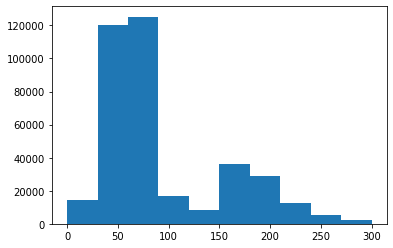

In [76]:
plt.hist(df_geo.exposures, range=[0, 300])
df_no_outlier = df_geo

0.0 180.0 -180.0 180.0


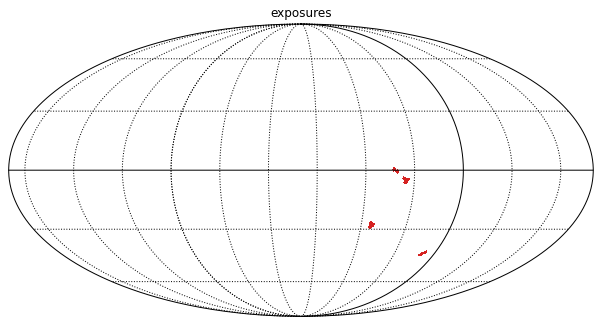

In [105]:
elem = 'exposures'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### b. pixel_id -> Plotting State of Current Catalogue



0.0 180.0 -180.0 180.0


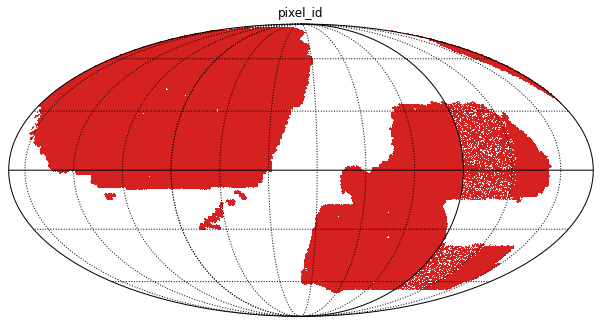

In [107]:
elem = 'pixel_id'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] < 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### c. lrg


0.0 180.0 -180.0 180.0


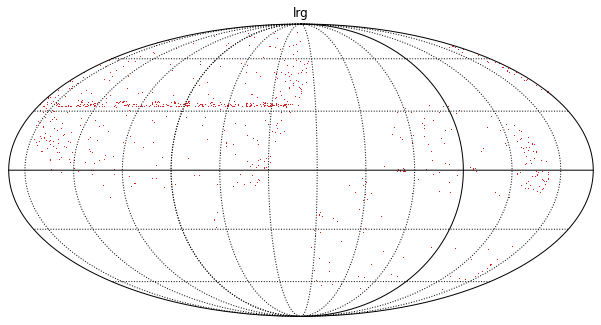

In [108]:
elem = 'lrg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### d. elg


0.0 180.0 -180.0 180.0


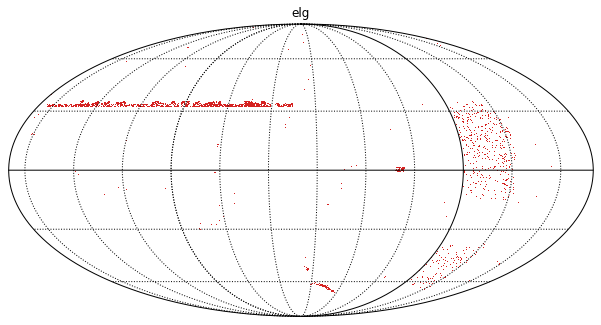

In [109]:
elem = 'elg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. qso


0.0 180.0 -180.0 180.0


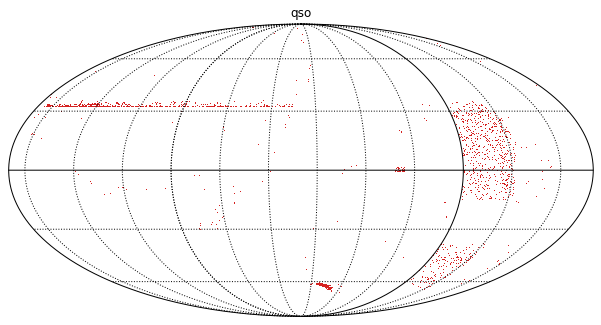

In [110]:
elem = 'qso'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. stellar


0.0 180.0 -180.0 180.0


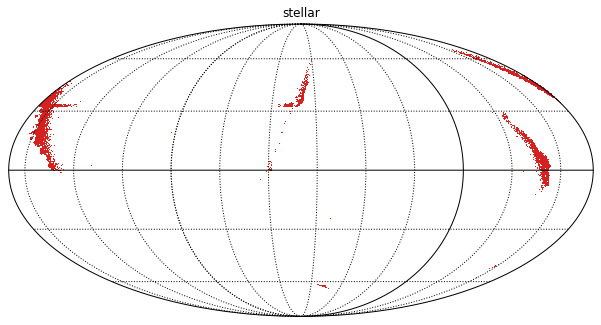

In [114]:
elem = 'stellar'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### f. EBV



0.0 180.0 -180.0 180.0


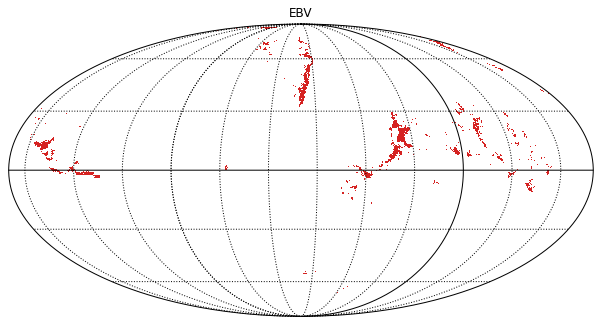

In [115]:
elem = 'EBV'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### g. exptime_g

0.0 180.0 -180.0 180.0


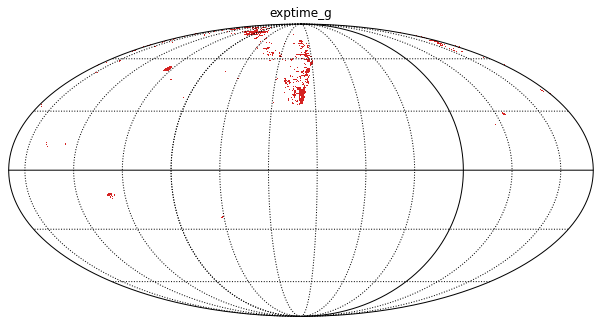

In [116]:
elem = 'exptime_g'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()


#### Plotting All combined

In [120]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')
print(len(cols))

25


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/rotator.py:646: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


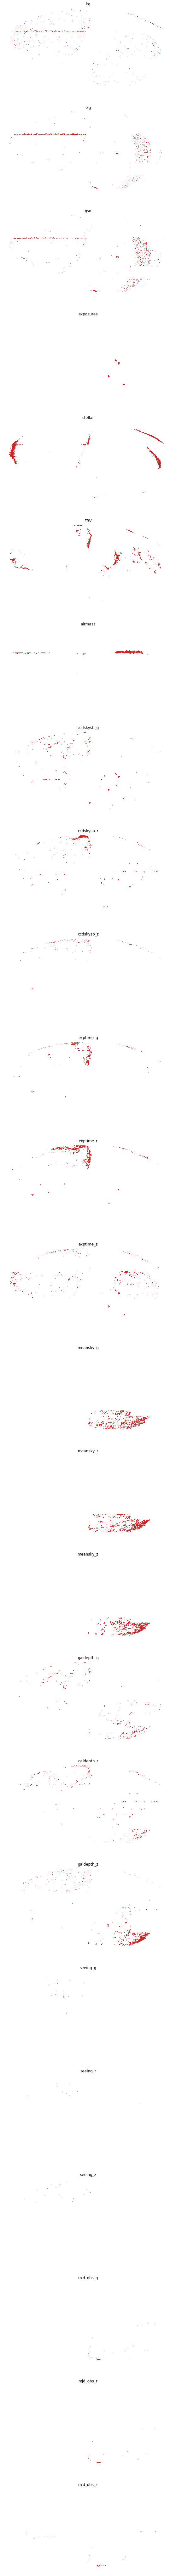

In [151]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(150,150))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]
    df_no_outlier['Z'] = df_geo[elem].transform(zscore)

    df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

    m = np.zeros(NPIX)

    m[df_outlier.pixel_id.to_numpy()] = 1
    mask = (m == 0)
    m[mask] = np.nan

    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1), min=-5, max=2, cbar=False, cmap="Reds", notext=False,
                rot=(100, 0, 0), badcolor='white',
                remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()
